# DDR Final Project
## Formula - 1 Data scrape
### Group 1 - Yajur Sehra, Rohit Desai, Hanyue Yao

In [10]:
#importing libraries
from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import os
new_directory = 'C:/Users/yajur/Downloads/'
os.chdir(new_directory)

print( os.getcwd())

C:\Users\yajur\Downloads


## Fetching data through Selenium and saving HTML

In [18]:
driver = webdriver.Chrome()

driver.implicitly_wait(10)
driver.set_script_timeout(120)
driver.set_page_load_timeout(10)

#navigating to ESPN website

driver.get('https://www.espn.com/')
time.sleep(3)

#finding search button
search = driver.find_element(By.CSS_SELECTOR, 'li.search')
search.click()

time.sleep(3)

#selecting that search button and inputing "Formula One" in the search bar
type = driver.find_element(By.CSS_SELECTOR,'input[aria-label = "Search"]')
type.send_keys('Formula One\n')

time.sleep(5)

#clicking the tile that takes us to the F1 page
f1 = driver.find_element(By.CSS_SELECTOR, 'section[class = "Card"]')
f1.click()
time.sleep(5)

#navigating to the standings page
standings = driver.find_element(By.LINK_TEXT, 'Standings')
standings.click()

time.sleep(5)

#fetching the current url
current_url = driver.current_url
print("Current URL:", current_url)

#Setting up a loop to add year ahead of url, so it takes us to that year's results and then saves that HTML locally.
for year in range(2023, 2012, -1):
    
    year_url = f'{current_url}/_/season/{year}'

    driver.get(year_url)
    

    time.sleep(5)
    

    html_source = driver.page_source
    
  
    with open(f'page_source_{year}.html', 'w', encoding='utf-8') as f:
        f.write(html_source)
        print(f"HTML for the year {year} saved")


driver.quit()

Current URL: https://www.espn.com/f1/standings
HTML for the year 2023 saved
HTML for the year 2022 saved
HTML for the year 2021 saved
HTML for the year 2020 saved
HTML for the year 2019 saved
HTML for the year 2018 saved
HTML for the year 2017 saved
HTML for the year 2016 saved
HTML for the year 2015 saved
HTML for the year 2014 saved
HTML for the year 2013 saved


### Successfully saved past 11 years of race results, we can go upto 1950 if we want to fetch older data and use that for analysis

## Creating functions to enter data in SQL database

In [12]:
import mysql.connector
from mysql.connector import Error
import re

In [13]:

# Function to create the database
def create_database(cursor, database_name):
    try:
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
        print(f"Database {database_name} created successfully.")
    except Error as e:
        print(f"Error creating database: {e}")

In [14]:
# Function to create the table
def create_table(cursor, table_name):
    try:
        table_creation_query = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            Year INT,
            Position INT,
            DriverName VARCHAR(255),
            Points INT
        )
        """
        cursor.execute(table_creation_query)
        print(f"Table {table_name} created successfully.")
    except Error as e:
        print(f"Error creating table: {e}")

In [15]:
# Function to insert data into the table
def insert_user_data(cursor, table_name, year, position, driver_name, points):
    insert_query = f"""
        INSERT INTO {table_name} (Year, Position, DriverName, Points)
        VALUES (%s, %s, %s, %s)
    """
    try:
        cursor.execute(insert_query, (year, position, driver_name, points))
        print(f"Data inserted successfully: {position}, {driver_name}, {points}")
    except Error as e:
        print(f"Error inserting data: {e}")


In [16]:
# Database parameters
database_name = 'f1_data'
table_name = 'standings'

# Establish a DB connection
connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Davis@12345678'
)

cursor = connection.cursor()
create_database(cursor, database_name) #calling function
cursor.execute(f"USE {database_name}")
create_table(cursor, table_name) # calling function

Database f1_data created successfully.
Table standings created successfully.


## Using BeautifulSoup and saving html files data in SQL

In [17]:
# setting path from where we will fetch the saved HTML files
path = 'DDR_Final' 

# Parse HTML files and insert data into the database, using BeautifulSoup to fetch data from the HTML files
for filename in os.listdir(path):
    if filename.endswith(".html"):
        filepath = os.path.join(path, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            html = file.read()
        soup = BeautifulSoup(html, 'html.parser')
        drivers_table = soup.find('tbody', class_='Table__TBODY')
        driver_rows = drivers_table.find_all('tr', limit=10)  # Only taking top 10 of each year
        year = int(re.search(r'\d{4}', filename).group())  #Using REGEX to fetch year from the filename

    
            
        #loop to run for all saved files    
        for index, row in enumerate(driver_rows, start=1):
            cells = row.find_all('td')
            position = index

            
            driver_text = row.find('td').get_text(strip=True)
            driver_name = driver_text[4:]

            
            points_text = cells[-1].get_text(strip=True)
            points = float(points_text) if '.' in points_text else int(points_text)

            print(f"{position}) {driver_name} - {points}") #printing in the desired format

           
            insert_user_data(cursor, table_name, year, position, driver_name, points) #calling function to enter data in SQL


# Commit changes and close the db connection
connection.commit()
if connection.is_connected():
    cursor.close()
    connection.close()
    print("MySQL connection is closed")


1) Sebastian Vettel - 397
Data inserted successfully: 1, Sebastian Vettel, 397
2) Fernando Alonso - 242
Data inserted successfully: 2, Fernando Alonso, 242
3) Mark Webber - 199
Data inserted successfully: 3, Mark Webber, 199
4) Lewis Hamilton - 189
Data inserted successfully: 4, Lewis Hamilton, 189
5) Kimi Raikkonen - 183
Data inserted successfully: 5, Kimi Raikkonen, 183
6) Nico Rosberg - 171
Data inserted successfully: 6, Nico Rosberg, 171
7) Romain Grosjean - 132
Data inserted successfully: 7, Romain Grosjean, 132
8) Felipe Massa - 112
Data inserted successfully: 8, Felipe Massa, 112
9) Jenson Button - 73
Data inserted successfully: 9, Jenson Button, 73
10) LNico Hülkenberg - 51
Data inserted successfully: 10, LNico Hülkenberg, 51
1) Lewis Hamilton - 384
Data inserted successfully: 1, Lewis Hamilton, 384
2) Nico Rosberg - 317
Data inserted successfully: 2, Nico Rosberg, 317
3) Daniel Ricciardo - 238
Data inserted successfully: 3, Daniel Ricciardo, 238
4) Sebastian Vettel - 190
Data 

Below is the image of sql workbench showing stored data and basic query to show the result

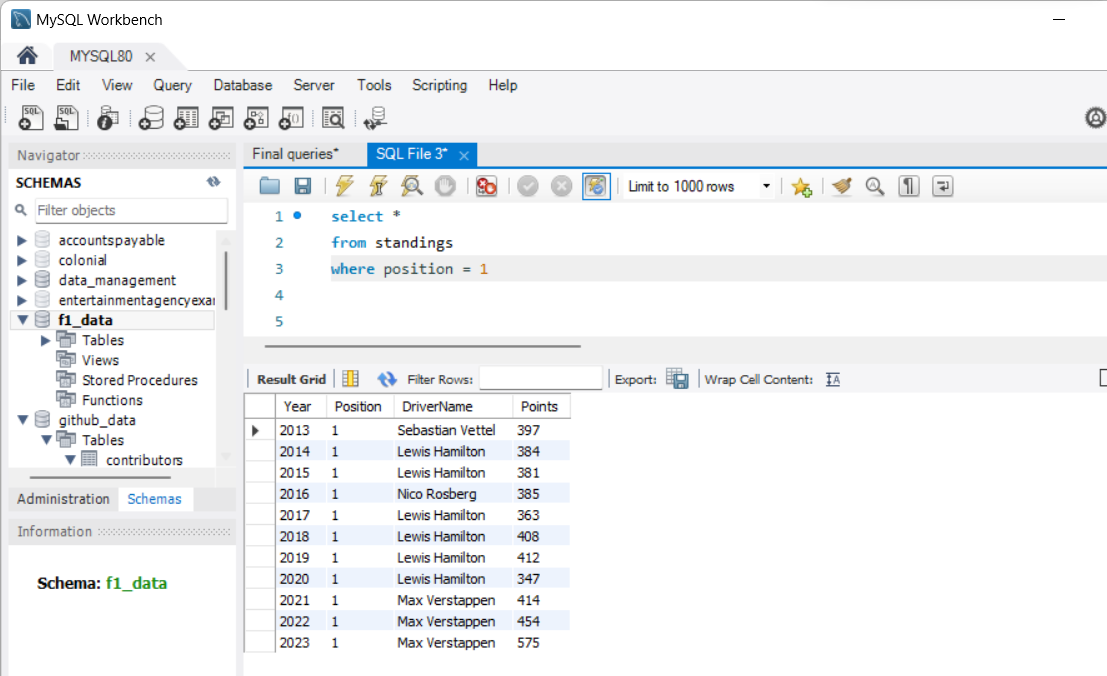